In [6]:
import pickle
import os
import pandas as pd
import numpy as np
import sklearn
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.externals import joblib
import pickle
# Added version check for recent scikit-learn 0.18 checksok ca
from distutils.version import LooseVersion as Version
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import train_test_split
##############----########### Take out what is redundant below###
from sklearn.linear_model import ElasticNet, Lasso, RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import roc_curve

# useful functions

In [7]:
def off_set(array_1, array_2):
    off_set= len(array_1)-len(array_2)
    return off_set

def simpleInputs(_X,_y):
    _offset =np.abs(off_set(_X,_y))
    if _offset==0:
        X = _X.as_matrix().astype(np.float)
        y=_y.astype(np.int)
    else:
        X= _X[:-_offset].as_matrix().astype(np.float)
        y = _y.astype(np.int)
    return X, y

In [9]:
symbols=['MS.N',
 'HSBA.L',
 'YHOO.O',
 'LMT.N',
 'GD.N',
 'DBKGn.DE',
 'LMT',
 'C.N','GS.N','GOOG.OQ']  
for _idx, _name in enumerate(symbols):
    print _idx, _name

0 MS.N
1 HSBA.L
2 YHOO.O
3 LMT.N
4 GD.N
5 DBKGn.DE
6 LMT
7 C.N
8 GS.N
9 GOOG.OQ


# paths

In [30]:
_no=0 #which symbol to take
# Where to save the figures
_pkl_path =('/home/ak/Documents/features_test/')
ticker=symbols[_no] #enter symbol you want - this will be made for various

_graphs_path= '/home/ak/Documents/Data/features_test/graphs/'
_models_path = '/home/ak/Documents/Data/features_test/models/'
_predictions_path ='/home/ak/Documents/Data/features_test/predictions/'
import sys
sys.path.append('/home/ak/Documents/Research/QFPaper/Huber-Norm-Regularizer')
from huber_svm import HuberSVC

In [11]:
os.listdir(_pkl_path)

['LMT.N_features.pickle',
 'models',
 'MS.N_labelled_data_2.pickle',
 'graphs',
 'MS.N_labelled_data.pickle',
 'C.N_features.pickle',
 'C.N_labelled_data.pickle',
 'LMT.N_features_2.pickle',
 'GS.N_features.pickle',
 'HSBA.L_features.pickle',
 'MS.N_features.pickle',
 'predictions',
 'LMT.N_labelled_data_2.pickle',
 'DBKGn.DE_features.pickle',
 'LMT.N_labelled_data.pickle',
 'GD.N_features.pickle',
 'GD.N_labelled_data_2.pickle',
 'DBKGn.DE_labelled_data.pickle',
 'GD.N_features_2.pickle',
 'GD.N_labelled_data.pickle',
 'DBKGn.DE_labelled_data_2.pickle',
 'HSBA.L_labelled_data.pickle',
 'GS.N_labelled_data.pickle',
 'C.N_clfs_.pkl',
 'DBKGn.DE_features_2.pickle',
 'MS.N_features_2.pickle']

In [12]:
print('Using Symbol:',ticker)

('Using Symbol:', 'MS.N')


# Main Code

In [13]:
##load data
with open(_pkl_path + ticker+'_features_2.pickle', 'rb') as handle:
    ticker_features_ = pickle.load(handle)
with open(_pkl_path + ticker+'_labelled_data_2.pickle', 'rb') as handle:
    ticker_labelled_data_ = pickle.load(handle)

_model_results= {
    'clfs': np.empty((M, T)),
    'test_F1': np.empty((M, T)),
    'data_date': np.empty((M, T)),
    'test_recall': np.empty((M, T)),
    'train_recall': np.empty((M, T)),
    'test_accuracy' :np.empty((M, T)),
    'train_accuracy' :np.empty((M, T)),
}

# Data Visualisation 

In [14]:
###the following bit is a bit redundant###
_data = ticker_labelled_data_  # data
_features = ticker_features_  # features
_keys = _data.keys()  # dates
###scalers###
mms = MinMaxScaler()
stdsc = StandardScaler()
_clfs=[]
_xr=len(_keys)-1
T=1
M=_xr

In [15]:
_columns=_data[_keys[1]].columns.values


In [16]:
_idx_=1
labels_cc_1=_data[_keys[_idx_]].iloc[:,4].dropna() #label_control_chart_q_40_q_70_window_15
labels_cc_2=_data[_keys[_idx_]].iloc[:,6].dropna()
short_rolling = _data[_keys[_idx]]['TradedPrice'].rolling(window=5).mean()
long_rolling = _data[_keys[_idx]]['TradedPrice'].rolling(window=10).mean()
ma_signal = (long_rolling - short_rolling).fillna(0)
  # feature set
_df=pd.concat([_features[_keys[_idx]][0],
               _features[_keys[_idx]][1],
               _features[_keys[_idx]][2] ,
               _features[_keys[_idx]][3], 
               pd.DataFrame(_data[_keys[_idx]]['TradedPrice']) ]
              ,axis=1)
_df['ma_signal']=_df['TradedPrice'].rolling(window=5).mean() -_df['TradedPrice'].rolling(window=15).mean()
#X=_df.drop['TradedPrice'].dropna()
#y=_df['TradedPrice'].dropna()
_df.columns.values


_shift=3

y_test=_df['TradedPrice'].shift(-_shift).values.ravel()
y_test = y_test[~np.isnan(y_test)]

x_test=_df.iloc[:,0:17][_shift:]
x_test = x_test[~np.isnan(x_test)]
len(x_test)-len(y_test)
y_=y_test
x_=x_test#.reshape(-1,1)
##
#x_.info()

len(y_test)==len(x_test)

True

In [18]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(_df.values)
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(_df.values)
imputed_data = imr.transform(_df)
#pd.DataFrame(imputed_data)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5]),
 <a list of 17 Text xticklabel objects>)

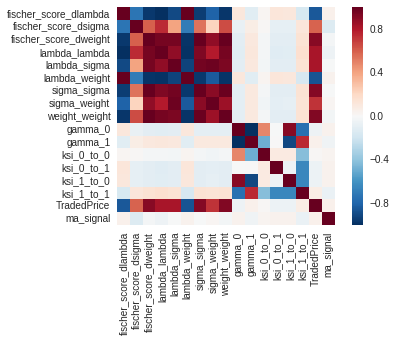

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
cm = x_.corr()
sns.heatmap(cm, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

In [21]:
print("#of models:",_xr)
print("for ticker:", ticker)
for symbol in symbols:
    for _idx in xrange(0, _xr): #replace this w _xr
        print symbol, _idx
        y_duration = _data[_keys[_idx]].iloc[:, 3].dropna().astype(int).values
        y_price = _data[_keys[_idx]].iloc[:, 1].dropna().astype(int).values #
        print(len(y_price))

('#of models:', 19)
('for ticker:', 'MS.N')
MS.N 0
1760
MS.N 1
4589
MS.N 2
3434
MS.N 3
2089
MS.N 4
2167
MS.N 5
2584
MS.N 6
1911
MS.N 7
2219
MS.N 8
2480
MS.N 9
1755
MS.N 10
2443
MS.N 11
1957
MS.N 12
2879
MS.N 13
2288
MS.N 14
1706
MS.N 15
1673
MS.N 16
2247
MS.N 17
3039
MS.N 18
1845
HSBA.L 0
1760
HSBA.L 1
4589
HSBA.L 2
3434
HSBA.L 3
2089
HSBA.L 4
2167
HSBA.L 5
2584
HSBA.L 6
1911
HSBA.L 7
2219
HSBA.L 8
2480
HSBA.L 9
1755
HSBA.L 10
2443
HSBA.L 11
1957
HSBA.L 12
2879
HSBA.L 13
2288
HSBA.L 14
1706
HSBA.L 15
1673
HSBA.L 16
2247
HSBA.L 17
3039
HSBA.L 18
1845
YHOO.O 0
1760
YHOO.O 1
4589
YHOO.O 2
3434
YHOO.O 3
2089
YHOO.O 4
2167
YHOO.O 5
2584
YHOO.O 6
1911
YHOO.O 7
2219
YHOO.O 8
2480
YHOO.O 9
1755
YHOO.O 10
2443
YHOO.O 11
1957
YHOO.O 12
2879
YHOO.O 13
2288
YHOO.O 14
1706
YHOO.O 15
1673
YHOO.O 16
2247
YHOO.O 17
3039
YHOO.O 18
1845
LMT.N 0
1760
LMT.N 1
4589
LMT.N 2
3434
LMT.N 3
2089
LMT.N 4
2167
LMT.N 5
2584
LMT.N 6
1911
LMT.N 7
2219
LMT.N 8
2480
LMT.N 9
1755
LMT.N 10
2443
LMT.N 11
1957
LMT.N 12
28

In [ ]:
[(symbol,_idx) for symbol in symbols for _idx in range(0, _xr)]


In [22]:
# test_accuracy_=pd.DataFrame(_model_results['test_accuracy']).round(2)
# train_accuracy_=pd.DataFrame(_model_results['train_accuracy']).round(2)

%matplotlib inline
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
T=1
M=_xr
_learning_results= {
    'train_score': np.empty((M, T)),
    'train_std': np.empty((M, T)),
    'test_score': np.empty((M, T)),
    'test_std': np.empty((M, T)),    
}

In [23]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
n_jobs=1

print("#of models:",_xr)
print("for ticker:", ticker)
all_train_scores_mean=[]
all_train_scores_std=[]
all_test_scores_mean=[]
all_test_scores_std=[]
for _idx in xrange(0, _xr): #replace this w _xr
    # various types of labels
    y_cc = _data[_keys[_idx]].iloc[:, 6].dropna().astype(int).values  # label_simple_ep_window_5_thresh_0.00-last 4 are NaN
    y_duration = _data[_keys[_idx]].iloc[:, 3].dropna().astype(int).values
    y_price = _data[_keys[_idx]].iloc[:, 1].dropna().astype(int).values # can be used for regression

    # feature set
    _gamma = _features[_keys[_idx]][2]
    _csi = _features[_keys[_idx]][3]
    _info = _features[_keys[_idx]][1]
    _fischer = _features[_keys[_idx]][0]
    short_rolling = _data[_keys[_idx]]['TradedPrice'].rolling(window=5).mean()
    long_rolling = _data[_keys[_idx]]['TradedPrice'].rolling(window=15).mean()
    ma_signal = (long_rolling - short_rolling).fillna(0)
    
    df_features = pd.concat([_csi, _gamma, _fischer,_data[_keys[_idx]]['TradedPrice']], axis=1)
    
    df_features['MA_signal'] = df_features['TradedPrice'].rolling(window=15).mean()-df_features['TradedPrice'].rolling(window=5).mean()
    df_features=df_features.dropna()
        
    
    
    y_ = y_cc
    X, y = simpleInputs(df_features, y_)
    X_p, y = simpleInputs(df_features['MA_signal'], y_)
           
    # # Train a SVM classification model

    X_p= X_p.reshape(-1, 1)
    X_mms = X = mms.fit_transform(X)
    X,y = X_mms, y
    
    
    # score curves, each time with 20% data randomly selected as a validation set.
    train_sizes=np.linspace(.1, 1.0, 5)
    title = str(ticker)+" Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
    # SVC is more expensive so we do a lower number of CV iterations:
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    estimator = SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
                    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
                    max_iter=-1, probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False)
    n_jobs=4
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    all_train_scores_mean.append(np.mean(train_scores, axis=1))
    all_train_scores_std.append(np.std(train_scores, axis=1))
    all_test_scores_mean.append(np.mean(test_scores, axis=1))
    all_test_scores_std.append(np.std(test_scores, axis=1))

('#of models:', 19)
('for ticker:', 'MS.N')


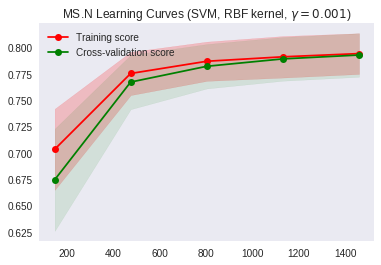

In [24]:
all_train_scores_mean=np.array(all_train_scores_mean)
all_test_scores_mean=np.array(all_test_scores_mean)

_train_scores_std=all_train_scores_mean.std(axis=0)
_train_scores_mean =all_train_scores_mean.mean(axis=0)

_test_scores_std=all_test_scores_mean.std(axis=0)
_test_scores_mean =all_test_scores_mean.mean(axis=0)
plt.figure()
title = str(ticker)+" Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
plt.title(title)
ylim=None
if ylim is not None:
    plt.ylim(*ylim)
plt.grid()
plt.fill_between(train_sizes, _train_scores_mean - _train_scores_std,
                     _train_scores_mean + _train_scores_std, alpha=0.2,
                     color="r")
plt.fill_between(train_sizes, _test_scores_mean - _test_scores_std,
                     _test_scores_mean + _test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, _train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, _test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()


In [26]:
_train_scores_mean/_train_scores_std

array([ 18.29999168,  37.81843111,  42.32954981,  40.20332221,  41.15157998])

In [27]:
_test_scores_mean/_test_scores_std

array([ 13.91705739,  29.81358021,  37.16791509,  38.10803673,  38.39507431])

In [38]:
lasso = OneVsRestClassifier(Lasso())
param_lasso = {'estimator__alpha': [100, 10, 1, 0.1, 1e-2, 1e-3]}

elastic = OneVsRestClassifier(ElasticNet())
param_elastic = {'estimator__alpha': [100, 10, 1, 0.1, 1e-2, 1e-3], 
                 'estimator__l1_ratio': np.linspace(0.01, 0.99, 5)}

ridge = RidgeClassifier(solver='lsqr')
param_ridge = {'alpha': [100, 10, 1, 0.1, 1e-2, 1e-3]}

huber = OneVsRestClassifier(HuberSVC())
param_huber = {'estimator__C': [100, 10, 1, 0.1, 1e-2, 1e-3], 
              'estimator__lambd': [100, 10, 1, 0.1, 1e-2, 1e-3], 
              'estimator__mu': [100, 10, 1, 0.1, 1e-2, 1e-3]}

param_lr = {
        'C':  np.arange(1.0, 3.0)
         , 'solver': ['newton-cg']
    }
lr_clf = LogisticRegression(penalty='l2', random_state=777, max_iter=10000, tol=10)

param_svc = dict(kernel=["linear","rbf"],C=[1,5,10,25,50],gamma=[0.0001,0.001,0.01])
svc_clf = svm.SVC(class_weight='balanced')
###see if the below works###
n_folds = 5
param_folds = 3
scoring = 'accuracy'

In [44]:
np.shape(X_mms)
np.shape(y)

(1826,)

result_df = pd.DataFrame()
best_clfs=[]
for i, (train_index, test_index) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
    for clf_name, clf, param_grid in [('Lasso', lasso, param_lasso), 
                                      ('ElasticNet', elastic, param_elastic), 
                                      ('Ridge', ridge, param_ridge),
                                      ('Logistic', lr_clf, param_lr),
                                      ('SVC',svc_clf, param_svc),
                                      ('HuberSVC', huber, param_huber)]:
        X=X_mms
        
        gs = GridSearchCV(clf, param_grid, scoring=scoring, cv=param_folds, n_jobs=-1, refit='AUC')
        gs.fit(X[train_index], y[train_index])
        best_clf = gs.best_estimator_
        best_clfs.append(best_clf)

        score = accuracy_score(y[test_index], best_clf.predict(X[test_index]))
        result_df.loc[i, clf_name] = score

In [40]:
X=X_mms
gs = GridSearchCV(clf, param_grid, scoring=scoring, cv=param_folds, n_jobs=-1, refit='AUC')
gs.fit(X[train_index], y[train_index])

NameError: name 'clf' is not defined

In [45]:
result_df = pd.DataFrame()
X=X_mms

cv=StratifiedKFold(n_splits=n_folds)
for i, (train_index, test_index) in enumerate(cv.split(X,y)):
    for clf_name, clf, param_grid in [('Lasso', lasso, param_lasso), 
                                      ('ElasticNet', elastic, param_elastic), 
                                      ('Ridge', ridge, param_ridge), 
                                      ('HuberSVC', huber, param_huber)]:

        gs = GridSearchCV(clf, param_grid, scoring=scoring, cv=param_folds, n_jobs=-1)
        gs.fit(X[train_index], y[train_index])
        best_clf = gs.best_estimator_

        score = accuracy_score(y[test_index], best_clf.predict(X[test_index]))
        result_df.loc[i, clf_name] = score

TypeError: __init__() got an unexpected keyword argument 'n_folds'